In [1]:
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import time

import sklearn

In [2]:
df = pd.read_csv('ISIC_2020_Training_GroundTruth_v2.csv')
df.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


In [3]:
df.benign_malignant.unique()

array(['benign', 'malignant'], dtype=object)

In [4]:
df.target.unique()

array([0, 1])

In [5]:
df.target.value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

In [6]:
df.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   lesion_id                      33126 non-null  object 
 3   sex                            33061 non-null  object 
 4   age_approx                     33058 non-null  float64
 5   anatom_site_general_challenge  32599 non-null  object 
 6   diagnosis                      33126 non-null  object 
 7   benign_malignant               33126 non-null  object 
 8   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 2.3+ MB


In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) + '.jpg'
        image = read_image(img_path)/255
        #print(image)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
batch_size=5
train_number=int(len(df)*0.8)
valid_number=len(df)-train_number

In [9]:
transform = transforms.Compose([
            transforms.RandomResizedCrop(224)
        ])

dataset = CustomImageDataset(img_labels=df[['image_name', 'benign_malignant']], img_dir='./train', transform=transform)
all_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, pin_memory=False, num_workers=6)

mean = 0.
std = 0.
for images, _ in all_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(all_loader.dataset)
std /= len(all_loader.dataset)

print(mean, std)

KeyboardInterrupt: 

In [5]:
#normalize = transforms.Normalize(mean=[0.8238, 0.6281, 0.5910], std=[0.0659, 0.0895, 0.1105]) #only for custom NN

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #for any imported model

transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
    #ajouter d'autres transforms
            normalize
        ])

dataset = CustomImageDataset(img_labels=df[['image_name', 'target']], img_dir='./train', transform=transform)
train_set, valid_set = torch.utils.data.random_split(dataset, [train_number, valid_number])


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=6)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 224, 224])


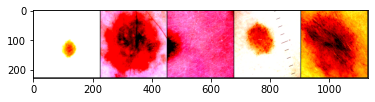

tensor(0) tensor(0) tensor(0) tensor(0) tensor(0)


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

In [7]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    #nn.Dropout(p=0.1, inplace=False),
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=4096, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=256, out_features=1, bias=True),
    torch.nn.Sigmoid()
    
    #nn.ReLU(inplace=True),
    #nn.Dropout(p=0.1, inplace=False),
    #nn.Linear(in_features=100, out_features=4, bias=True)
)
model.classifier = classifier

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.Sigmoid(input=2, output=1)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(torch.nn.functional.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

In [8]:

#model=Net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)


criterion = torch.nn.BCELoss(weight= torch.tensor([0.98237/0.01763]))

criterion.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def train(net, loader, criterion, optimizer, device):
    """Perform one epoch over the input set.

    Arguments:
      net : Input neural network
      loader : Data loader
      criterion : function to compute the loss
      optimizer :
      device : The device on which to run the computation

    """
    # Set the network to "training" mode
    net.train()

    total_loss = 0
    n_correct = 0
    
    
    #weight = torch.Tensor([584/32542])

    for i, (batch, target) in enumerate(loader):
        # Move both batch and target to the GPU
        # on the same device as the model and the
        # criterion.
        #
        # Don't forget that tensor needs assignment
        # (i.e. you need to do x = x.to(device), not
        # just x.to(device) like with a model)
        #batch = torch.tensor(batch, dtype=torch.float64, device=device)
        #target = torch.tensor(target).to(device)
        batch = batch.to(device)
        target = target.type(torch.float).to(device)

        # 1. Perform the forward pass on the mini-batch
        output = net.forward(batch)        
        output = output.view(-1)
        
        n_correct += count_nb_correct(output, target)

        # 2. Compute the loss (variable 'loss')
        loss = criterion(output, target)

        # 3. Run the backward pass :
        # a. Zero the values of the optimizer
        optimizer.zero_grad()
        # b. Compute the loss backward
        loss.backward()
        # c. Perform one step of optimizer
        optimizer.step()

        total_loss += loss.item()

    return total_loss, float(n_correct) / float(len(loader.dataset))


def count_nb_correct(output, target):
    """Count the number of correct labels compared to
    the ground truth

    Args:
        output: The output of a network, a tensor of size (n_samples, n_classes)
        target: The ground truth, returned by the DataLoader, a tensor of size (n_samples, )

    Returns:
        The number of correct labels

    """
    out = output.type(torch.int8)
    tar = target.type(torch.int8)

    return torch.eq(torch.argmax(out), tar).sum().item()


def validate(net, loader, device):
    # Set the network to evalution mode
    net.eval()

    # Total number of correctly classified samples
    n_correct = 0

    with torch.no_grad():
        for i, (batch, target) in enumerate(loader):
            # Move both batch and target to the GPU
            # on the same device as the model and the
            # criterion.
            batch = batch.to(device)
            target = torch.tensor(target).to(device)

            # 1. Perform the forward pass
            output = net.forward(batch)
            output = output.view(-1)

            # 2. Update 'n_correct'
            n_correct += count_nb_correct(output, target)

    return float(n_correct) / float(len(loader.dataset))


def plot_results(epochs, train_losses, valid_accuracies, figsize=(16,5)):
    """
    """
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, "r", label="Train loss")
    plt.title("Train loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, "r", label="Validation accuracy")
    plt.title("Validation accuracy")
    plt.legend()
    plt.show()

n_epochs = 10
epochs = []
train_losses = []
train_accuracies = []
valid_accuracies = []

print(f"The training is done on the {'GPU' if next(model.parameters()).is_cuda else 'CPU'}")

beg = time.perf_counter()
for epoch in range(n_epochs):
    # Perform training
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    epochs.append(epoch)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    # Test on validation set
    valid_accuracy = validate(model, valid_loader, device)
    valid_accuracies.append(valid_accuracy)
    print(f"epoch {epoch} loss {train_loss:.3f} train accuracy {100*train_accuracy:.2f}% validation accuracy {100*valid_accuracy:.2f}%")
print(f"Training took {time.perf_counter()-beg:.2f} seconds")
plot_results(epochs, train_losses, valid_accuracies)


def model_save(fn):
    with open(fn, 'wb') as f:
        torch.save([model, criterion, optimizer], f)


model_save('torch_cat.model')

The training is done on the GPU


<ipython-input-9-e41f822a5dcf>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).to(device)


epoch 0 loss 75392.396 train accuracy 98.20% validation accuracy 98.40%
epoch 1 loss 67735.227 train accuracy 98.20% validation accuracy 98.40%


KeyboardInterrupt: 